In [2]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid, RandomizedSearchCV, train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.svm import SVC
from scipy.stats import ks_2samp, randint
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import keras_tuner as kt
from scikeras.wrappers import KerasClassifier
from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm
import tempfile

# Set option to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set option to force dataframes to display numbers as floats with thousands separators
pd.set_option('display.float_format', '{:,.3f}'.format)  # Adjust decimal places as needed

Check https://www.kaggle.com/code/rikdifos/eda-vintage-analysis/notebook for variable definitions

### Data Preparation

In [3]:
# ------------------------------------------------------------------------
# 1. Load and inspect the data
# ------------------------------------------------------------------------
# Define the directory containing the CSV files
directory = ''

# Open the files in a DataFrame for viewing
application_raw_file = os.path.join(directory, 'application_record.csv')
app_record = pd.read_csv(application_raw_file)

credit_raw_file = os.path.join(directory, 'credit_record.csv')
credit_record = pd.read_csv(credit_raw_file)

In [3]:
app_record.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,"427,500.000",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.000
1,5008805,M,Y,Y,0,"427,500.000",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.000
2,5008806,M,Y,Y,0,"112,500.000",Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.000
3,5008808,F,N,Y,0,"270,000.000",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.000
4,5008809,F,N,Y,0,"270,000.000",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.000


In [64]:
app_record.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,"438,557.000","438,557.000","438,557.000","438,557.000","438,557.000","438,557.000","438,557.000","438,557.000","438,557.000","438,557.000"
mean,"6,022,176.270",0.427,"187,524.286","-15,997.905","60,563.675",1.000,0.206,0.288,0.108,2.194
std,"571,637.023",0.725,"110,086.853","4,185.030","138,767.800",0.000,0.405,0.453,0.311,0.897
min,"5,008,804.000",0.000,"26,100.000","-25,201.000","-17,531.000",1.000,0.000,0.000,0.000,1.000
25%,"5,609,375.000",0.000,"121,500.000","-19,483.000","-3,103.000",1.000,0.000,0.000,0.000,2.000
50%,"6,047,745.000",0.000,"160,780.500","-15,630.000","-1,467.000",1.000,0.000,0.000,0.000,2.000
75%,"6,456,971.000",1.000,"225,000.000","-12,514.000",-371.000,1.000,0.000,1.000,0.000,3.000
max,"7,999,952.000",19.000,"6,750,000.000","-7,489.000","365,243.000",1.000,1.000,1.000,1.000,20.000


In [65]:
credit_record.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [66]:
credit_record.describe()

,ID,MONTHS_BALANCE
count,"1,048,575.000","1,048,575.000"
mean,"5,068,286.425",-19.137
std,"46,150.579",14.023
min,"5,001,711.000",-60.000
25%,"5,023,644.000",-29.000
50%,"5,062,104.000",-17.000
75%,"5,113,856.000",-7.000
max,"5,150,487.000",0.000


Checking for duplicates by ID

In [4]:
# Identify IDs in app_record that appear more than once
duplicate_ids = app_record['ID'].value_counts()[lambda x: x > 1].index
duplicate_ids

Index([7137299, 7702238, 7282535, 7243768, 7050948, 7602432, 7036518, 7045885,
       7618285, 7089090, 7052783, 7416167, 7023108, 7045794, 7053557, 7207977,
       7836711, 7772847, 7154819, 7052812, 7099881, 7022327, 7833087, 7743418,
       7836971, 7372589, 7636756, 7636389, 7213374, 7317997, 7838075, 7023651,
       7155150, 7091721, 7046068, 7742298, 7744386, 7702516, 7022197, 7154598,
       7742853, 7090931, 7135270, 7024111, 7174719, 7603224, 7576316],
      dtype='int64', name='ID')

This ID example appears to be two completely unrelated people

In [68]:
app_record[app_record['ID'] == 7022197]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
425023,7022197,F,N,Y,0,"450,000.000",Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.000
426818,7022197,M,Y,Y,3,"135,000.000",Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.000


Fortunately the duplicated IDs don't exist in the credit record file

In [4]:
# Filter credit_record to include only rows with duplicate IDs from app_record
credit_record_duplicates = credit_record[credit_record['ID'].isin(duplicate_ids)]

print(credit_record_duplicates)

Empty DataFrame
Columns: [ID, MONTHS_BALANCE, STATUS]
Index: []


Remove duplicates in application record

In [5]:
app_record = app_record.groupby('ID').filter(lambda x: len(x) == 1)

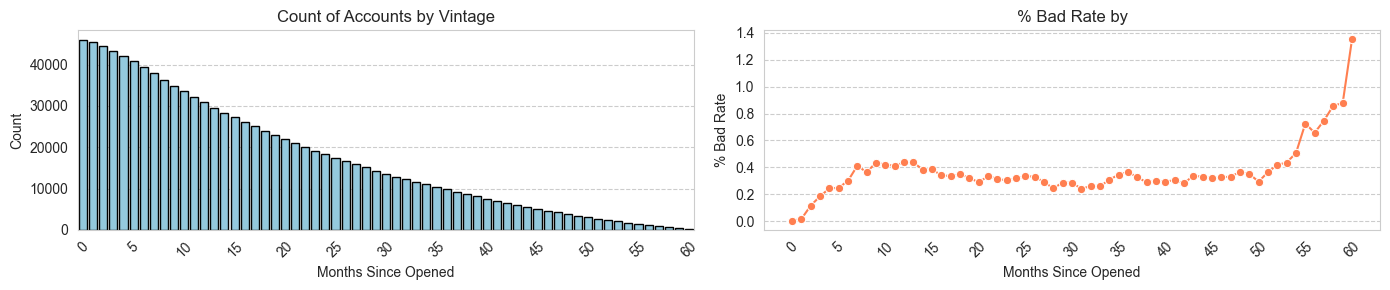

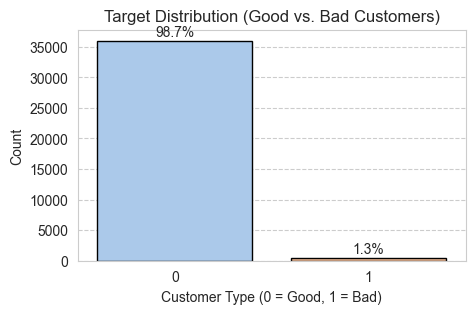

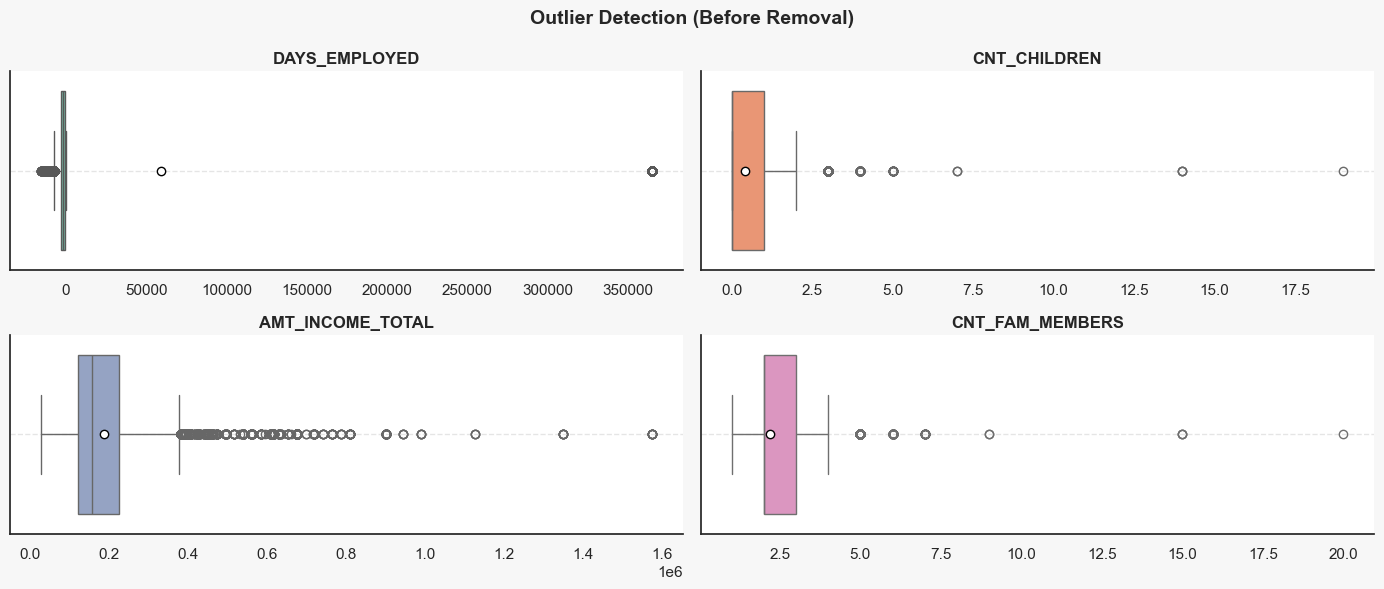

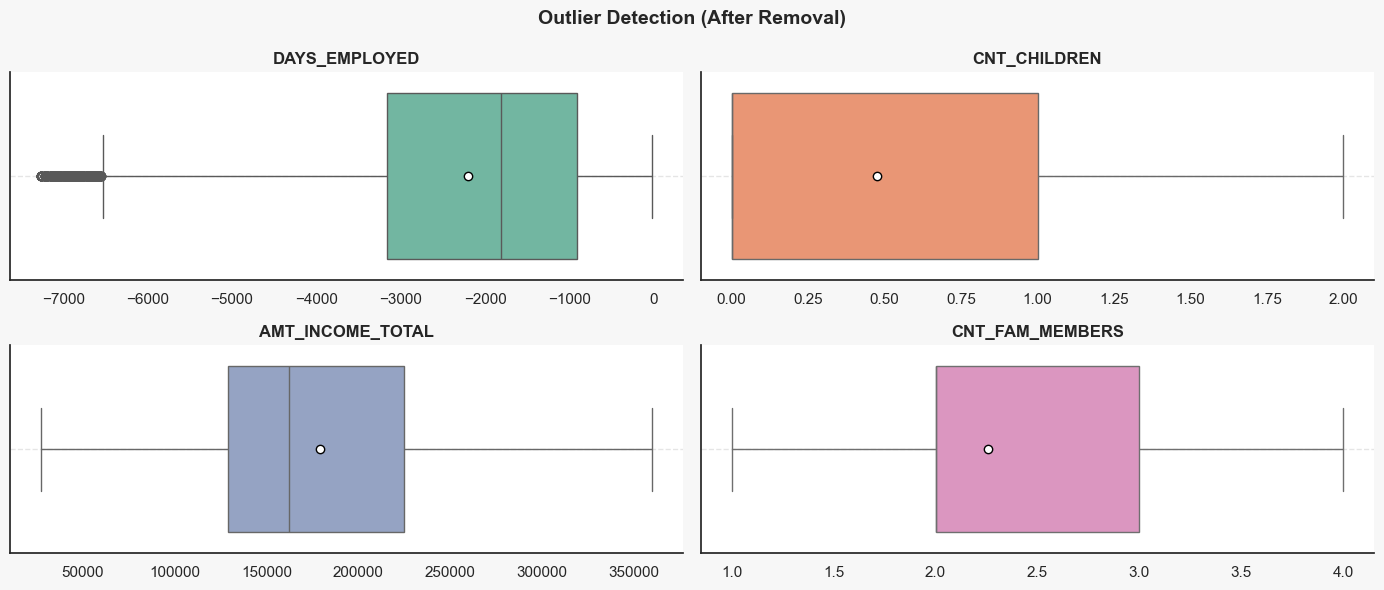

Original merged data shape: (36457, 19)
After outlier removal: (26663, 19)


In [6]:
# ------------------------------------------------------------------------
# 2. Determine the opening month for each customer
# ------------------------------------------------------------------------
opening_months = credit_record.groupby('ID')['MONTHS_BALANCE'].min().rename('opening_month')
credit_record = credit_record.merge(opening_months, on='ID', how='left')
credit_record['MONTHS_SINCE_OPENED'] = credit_record['MONTHS_BALANCE'] - credit_record['opening_month']

# ------------------------------------------------------------------------
# Visualize “Starting Month vs. Count” and Monthly Bad Rate
# ------------------------------------------------------------------------
sns.set_style("whitegrid")
month_distribution = credit_record.groupby('MONTHS_SINCE_OPENED')['ID'].count()

fig, ax = plt.subplots(1, 2, figsize=(14, 3))

# Left subplot: Starting Month vs. Count
sns.barplot(
    x=month_distribution.index,
    y=month_distribution.values,
    ax=ax[0],
    color='skyblue',
    edgecolor='black'
)
ax[0].set_xlabel('Months Since Opened', fontsize=10)
ax[0].set_ylabel('Count', fontsize=10)
ax[0].set_title('Count of Accounts by Vintage', fontsize=12)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].tick_params(axis='x', rotation=45)
ax[0].grid(True, which='both', axis='y', linestyle='--')
ax[0].grid(False, which='both', axis='x')

# Right subplot: Monthly Bad Rate
credit_record['bad_flag'] = credit_record['STATUS'].isin(['2','3','4','5']).astype(int)
bad_rate_df = credit_record.groupby('MONTHS_SINCE_OPENED')['bad_flag'].mean() * 100

sns.lineplot(
    x=bad_rate_df.index,
    y=bad_rate_df.values,
    ax=ax[1],
    color='coral',
    marker='o'
)
ax[1].set_xlabel('Months Since Opened', fontsize=10)
ax[1].set_ylabel('% Bad Rate', fontsize=10)
ax[1].set_title('% Bad Rate by', fontsize=12)
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(5))
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True, which='both', axis='y', linestyle='--')
ax[1].grid(False, which='both', axis='x')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------
# 3. Create the target variable (1=bad, 0=good) based on first 12 months
# ------------------------------------------------------------------------
first_year = credit_record[credit_record['MONTHS_SINCE_OPENED'] <= 12]
target_per_id = first_year.groupby('ID')['bad_flag'].max().rename('target')

# Use an inner join so only customers with 12-month coverage are included
app_record = app_record.merge(target_per_id, on='ID', how='inner')

# ------------------------------------------------------------------------
# Target Distribution (Good vs. Bad Customers)
# ------------------------------------------------------------------------
sns.set_style("whitegrid")
target_counts = app_record['target'].value_counts().sort_index()  # ensures order: 0 then 1

df_target = target_counts.reset_index()
df_target.columns = ['customer_type', 'count']

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(
    data=df_target,
    x='customer_type',
    y='count',
    hue='customer_type',
    palette="pastel",
    dodge=False,
    edgecolor="black",
    ax=ax
)
if ax.get_legend() is not None:
    ax.legend_.remove()

ax.set_xlabel("Customer Type (0 = Good, 1 = Bad)", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
ax.set_title("Target Distribution (Good vs. Bad Customers)", fontsize=12)
ax.grid(True, which='both', axis='y', linestyle='--')
ax.grid(False, which='both', axis='x')

total = target_counts.sum()
percentages = (target_counts / total * 100).round(1)
for i, row in df_target.iterrows():
    ax.text(i, row['count'] + total * 0.005, f"{percentages[i]}%", ha='center', va='bottom', fontsize=10)

plt.show()

# ------------------------------------------------------------------------
# 4. Handling Outliers (Visualization and Removal)
# ------------------------------------------------------------------------
def plot_boxplots(data, columns, title):
    """
    Plots a 2x2 grid of horizontal boxplots for the specified columns
    with cleaner styling (dashed horizontal grid, no vertical grid).
    """
    sns.set_theme(style='white', font_scale=1.0)
    custom_colors = sns.color_palette("Set2", n_colors=len(columns))

    fig, axes = plt.subplots(2, 2, figsize=(14, 6), facecolor="#F7F7F7")
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.boxplot(
            data=data,
            x=col,
            ax=axes[i],
            color=custom_colors[i],
            showmeans=True,
            meanprops={
                "marker": "o",
                "markerfacecolor": "white",
                "markeredgecolor": "black",
                "markersize": 6
            }
        )
        axes[i].set_title(col, fontsize=12, fontweight='semibold')
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
        axes[i].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
        axes[i].grid(False, which='major', axis='x')
        sns.despine(ax=axes[i], left=False, bottom=False)

    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Columns to inspect for outliers
columns_of_interest = ["DAYS_EMPLOYED", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS"]

# Visualize the original data (Before Outlier Removal)
plot_boxplots(app_record, columns_of_interest, title="Outlier Detection (Before Removal)")

def remove_outliers_iqr(df, col):
    """
    Removes outliers from df[col] based on the 1.5*IQR rule.
    Returns a filtered DataFrame with outliers removed.
    """
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR # post outlier removal figures look closer to the paper if we use 3.0 instead 1.5 here
    upper_fence = Q3 + 1.5 * IQR # post outlier removal figures look closer to the paper if we use 3.0 instead 1.5 here
    return df[(df[col] >= lower_fence) & (df[col] <= upper_fence)]

# Create a copy for outlier removal
app_record_clean = app_record.copy()

# Encode flags to numeric
app_record_clean['CODE_GENDER'] = app_record_clean['CODE_GENDER'].map({'M': 1, 'F': 0})
app_record_clean['FLAG_OWN_CAR'] = app_record_clean['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
app_record_clean['FLAG_OWN_REALTY'] = app_record_clean['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

# Apply IQR rule to each column in columns_of_interest
for col in columns_of_interest:
    app_record_clean = remove_outliers_iqr(app_record_clean, col)

# Visualize the clean data (After Outlier Removal)
plot_boxplots(app_record_clean, columns_of_interest, title="Outlier Detection (After Removal)")

# Optional: Print shape changes or summary stats
print("Original merged data shape:", app_record.shape)
print("After outlier removal:", app_record_clean.shape)

In [84]:
app_record_clean.head(1)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target,age_months,employment_months
2,5008806,1,1,1,0,"112,500.000",Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.000,0,706.000,37.000


Preview of final DataFrame:
         ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
2  5008806            1             1                1             0   
3  5008808            0             0                1             0   
4  5008809            0             0                1             0   
5  5008810            0             0                1             0   
6  5008811            0             0                1             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
2       112,500.000               Working  Secondary / secondary special   
3       270,000.000  Commercial associate  Secondary / secondary special   
4       270,000.000  Commercial associate  Secondary / secondary special   
5       270,000.000  Commercial associate  Secondary / secondary special   
6       270,000.000  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
2       

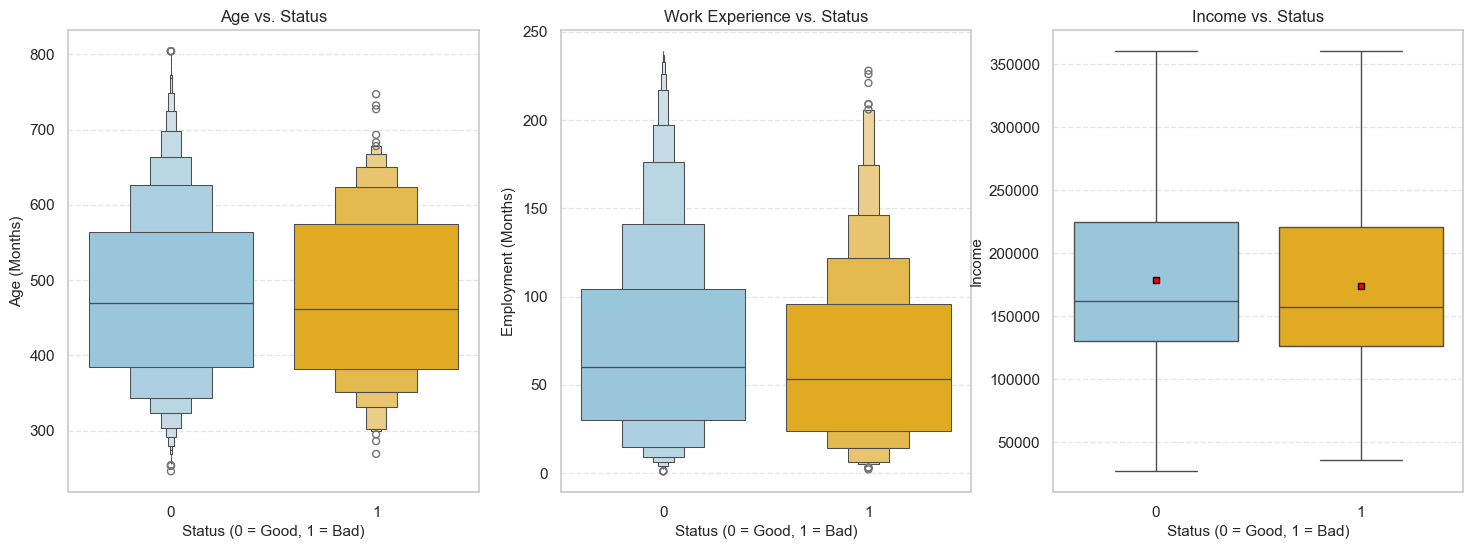

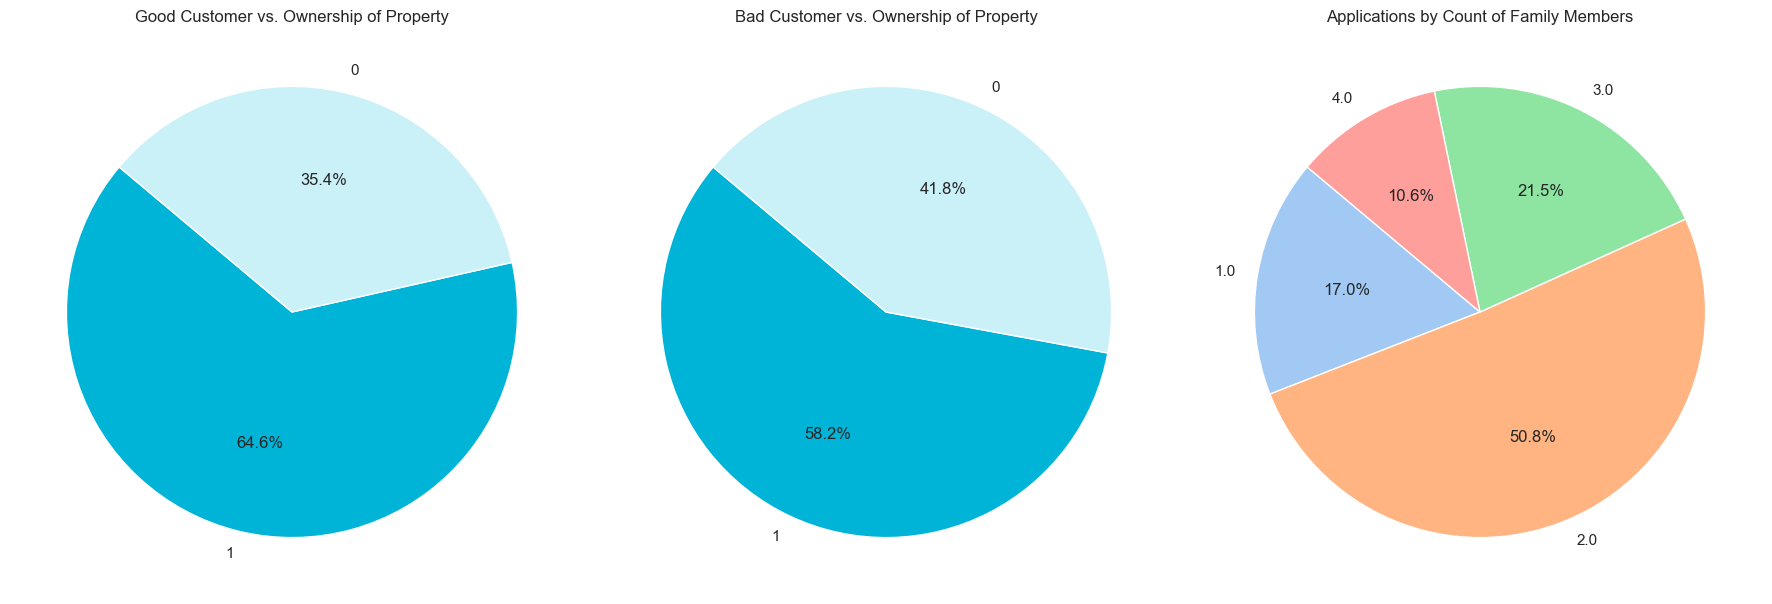

In [7]:
# Convert DAYS_BIRTH (negative day count) to a positive month count
# Using 30.4 days per month for a more precise conversion
if 'DAYS_BIRTH' in app_record_clean.columns:
    app_record_clean['age_months'] = (-app_record_clean['DAYS_BIRTH'] / 30.4).round(0)  # Round to whole months

# Convert DAYS_EMPLOYED (negative day count) to a positive month count
if 'DAYS_EMPLOYED' in app_record_clean.columns:
    app_record_clean['employment_months'] = (-app_record_clean['DAYS_EMPLOYED'] / 30.4).round(0)

print("Preview of final DataFrame:\n", app_record_clean.head())

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Age vs. Status (Boxen Plot)
sns.boxenplot(
    data=app_record_clean,
    x='target',
    y='age_months',
    hue='target',
    palette=['#8ecae6', '#ffb703'],
    ax=axes[0]
)
axes[0].set_title("Age vs. Status", fontsize=12)
axes[0].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[0].set_ylabel("Age (Months)", fontsize=11)
axes[0].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[0].grid(False, which='major', axis='x')
if axes[0].get_legend() is not None:
    axes[0].legend_.remove()

# 2) Work Experience vs. Status (Boxen Plot)
sns.boxenplot(
    data=app_record_clean,
    x='target',
    y='employment_months',
    hue='target',
    palette=['#8ecae6', '#ffb703'],
    ax=axes[1]
)
axes[1].set_title("Work Experience vs. Status", fontsize=12)
axes[1].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[1].set_ylabel("Employment (Months)", fontsize=11)
axes[1].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[1].grid(False, which='major', axis='x')
if axes[1].get_legend() is not None:
    axes[1].legend_.remove()


# Box Plot 3: Income vs. Status (with red square for average)
sns.boxplot(
    data=app_record_clean,
    x='target',
    y='AMT_INCOME_TOTAL',
    hue='target',  # same as x
    palette=['#8ecae6', '#ffb703'],
    showmeans=True,
    meanprops={
        'marker': 's',
        'markerfacecolor': 'red',  # specifically red for the mean
        'markeredgecolor': 'black',
        'markersize': 5
    },
    ax=axes[2]
)
axes[2].set_title("Income vs. Status", fontsize=12)
axes[2].set_xlabel("Status (0 = Good, 1 = Bad)", fontsize=11)
axes[2].set_ylabel("Income", fontsize=11)
axes[2].grid(True, which='major', axis='y', linestyle='--', alpha=0.5)
axes[2].grid(False, which='major', axis='x')
if axes[2].get_legend() is not None:
    axes[2].legend_.remove()


# ========== 2) Pie Charts for Property Ownership (Good vs. Bad) and Family Size ==========

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# (a) Good Customers vs. Ownership of Property
good_ownership = app_record_clean[app_record_clean['target'] == 0]['FLAG_OWN_REALTY'].value_counts()
axes[0].pie(
    good_ownership.values,
    labels=good_ownership.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#00b4d8', '#caf0f8']  # example colors
)
axes[0].set_title("Good Customer vs. Ownership of Property", fontsize=12)

# (b) Bad Customers vs. Ownership of Property
bad_ownership = app_record_clean[app_record_clean['target'] == 1]['FLAG_OWN_REALTY'].value_counts()
axes[1].pie(
    bad_ownership.values,
    labels=bad_ownership.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#00b4d8', '#caf0f8']
)
axes[1].set_title("Bad Customer vs. Ownership of Property", fontsize=12)

# (c) Applications by Family Members
fam_counts = app_record_clean['CNT_FAM_MEMBERS'].value_counts().sort_index()
axes[2].pie(
    fam_counts.values,
    labels=fam_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel", n_colors=len(fam_counts))
)
axes[2].set_title("Applications by Count of Family Members", fontsize=12)

plt.tight_layout()
plt.show()

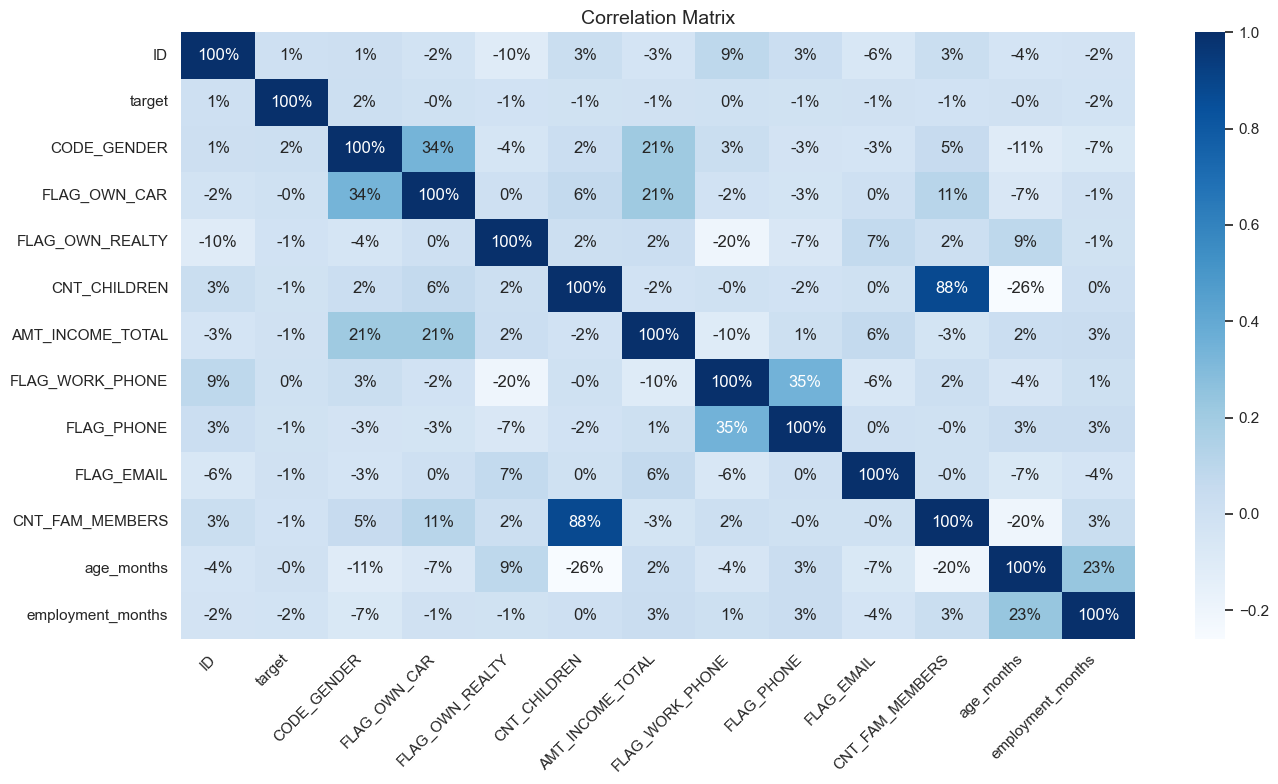

In [8]:
# Select columns for correlation (adjust as needed)
corr_cols = ['ID', 'target', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'age_months', 'employment_months'
]
df_corr = app_record_clean[corr_cols].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr()

plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='Blues',
    fmt=".0%",  # Formats the correlation as a percentage with zero decimals
    square=False,
    cbar=True
)

# Remove vertical gridlines and set horizontal gridlines to dashed
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle='--')

plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Pre-processing

In [9]:
# ------------------------------------------------------------------------
# One-hot encode categorical variables
# ------------------------------------------------------------------------

# List the categorical columns to one-hot encode
categorical_cols = [
    'NAME_INCOME_TYPE', 
    'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE', 
    'OCCUPATION_TYPE'
]

# One-hot encode the specified categorical columns in app_record_clean
# The parameter drop_first=True avoids the dummy variable trap by dropping the first category
app_record_clean_encoded = pd.get_dummies(app_record_clean, columns=categorical_cols, drop_first=True)

In [90]:
app_record_clean_encoded.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,target,age_months,employment_months,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
2,5008806,1,1,1,0,"112,500.000",-21474,-1134,1,0,0,0,2.000,0,706.000,37.000,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,5008808,0,0,1,0,"270,000.000",-19110,-3051,1,0,1,1,1.000,0,629.000,100.000,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,5008809,0,0,1,0,"270,000.000",-19110,-3051,1,0,1,1,1.000,0,629.000,100.000,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
5,5008810,0,0,1,0,"270,000.000",-19110,-3051,1,0,1,1,1.000,0,629.000,100.000,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
6,5008811,0,0,1,0,"270,000.000",-19110,-3051,1,0,1,1,1.000,0,629.000,100.000,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
10,5008815,1,1,1,0,"270,000.000",-16872,-769,1,1,1,1,2.000,0,555.000,25.000,False,False,False,True,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
11,5112956,1,1,1,0,"270,000.000",-16872,-769,1,1,1,1,2.000,0,555.000,25.000,False,False,False,True,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
12,5008819,1,1,1,0,"135,000.000",-17778,-1194,1,0,0,0,2.000,0,585.000,39.000,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
13,5008820,1,1,1,0,"135,000.000",-17778,-1194,1,0,0,0,2.000,0,585.000,39.000,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
14,5008821,1,1,1,0,"135,000.000",-17778,-1194,1,0,0,0,2.000,0,585.000,39.000,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,Fa

In [10]:
# ------------------------------------------------------------------------
# Build final dataframe with chosen features
# ------------------------------------------------------------------------

# List of base variables to keep for analysis
base_cols = [
    'target', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
    'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'age_months', 'employment_months'
]

# Identify the one-hot encoded columns created from categorical variables.
# These columns start with the original variable name followed by an underscore.
encoded_cols = [col for col in app_record_clean_encoded.columns 
                if col.startswith('NAME_INCOME_TYPE_') or 
                   col.startswith('NAME_EDUCATION_TYPE_') or 
                   col.startswith('NAME_FAMILY_STATUS_') or 
                   col.startswith('NAME_HOUSING_TYPE_') or 
                   col.startswith('OCCUPATION_TYPE_')]

# Combine base columns and encoded columns into a single list of columns to keep
selected_cols = base_cols + encoded_cols

# Create the final DataFrame with only these columns
final_df = app_record_clean_encoded[selected_cols]


In [12]:
# ------------------------------------------------------------------------
# 1) Split target from dataset
# ------------------------------------------------------------------------
# Assume final_df is the final preprocessed DataFrame with 'target' (0 = good, 1 = bad)
X = final_df.drop('target', axis=1)  # Features
y = final_df['target']               # Labels

# ------------------------------------------------------------------------
# 2) Drop useless features
# ------------------------------------------------------------------------
X = X.drop(['CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1)

# ------------------------------------------------------------------------
# 3) Split dataset into Train and Test Sets (70:30)
# ------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ------------------------------------------------------------------------
# 4) Normalize inputs on the training set and transform the test set using the same scalers
# ------------------------------------------------------------------------
# Define separate scalers for each column
CNT_CHILDREN_scaler = MinMaxScaler()
AMT_INCOME_TOTAL_scaler = MinMaxScaler()
CNT_FAM_MEMBERS_scaler = MinMaxScaler()
age_months_scaler = MinMaxScaler()
employment_months_scaler = MinMaxScaler()

# Fit and transform on training set
X_train['CNT_CHILDREN'] = CNT_CHILDREN_scaler.fit_transform(X_train[['CNT_CHILDREN']])
X_train['AMT_INCOME_TOTAL'] = AMT_INCOME_TOTAL_scaler.fit_transform(X_train[['AMT_INCOME_TOTAL']])
X_train['CNT_FAM_MEMBERS'] = CNT_FAM_MEMBERS_scaler.fit_transform(X_train[['CNT_FAM_MEMBERS']])
X_train['age_months'] = age_months_scaler.fit_transform(X_train[['age_months']])
X_train['employment_months'] = employment_months_scaler.fit_transform(X_train[['employment_months']])

# Transform test set using the scalers fitted on the training set
X_test['CNT_CHILDREN'] = CNT_CHILDREN_scaler.transform(X_test[['CNT_CHILDREN']])
X_test['AMT_INCOME_TOTAL'] = AMT_INCOME_TOTAL_scaler.transform(X_test[['AMT_INCOME_TOTAL']])
X_test['CNT_FAM_MEMBERS'] = CNT_FAM_MEMBERS_scaler.transform(X_test[['CNT_FAM_MEMBERS']])
X_test['age_months'] = age_months_scaler.transform(X_test[['age_months']])
X_test['employment_months'] = employment_months_scaler.transform(X_test[['employment_months']])

# ------------------------------------------------------------------------
# 5) Print training set distribution before SMOTE
# ------------------------------------------------------------------------
print("Training set before SMOTE:")
print("Overall label distribution (proportion):")
print(y_train.value_counts(normalize=True).round(3))
print("Pre SMOTE - Good customers:", y_train.value_counts()[0])
print("Pre SMOTE - Bad customers:", y_train.value_counts()[1])

# ------------------------------------------------------------------------
# 6) Oversample the training dataset using SMOTE
# ------------------------------------------------------------------------
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("\nTraining set post SMOTE:")
print("Overall label distribution (proportion):")
print(y_res.value_counts(normalize=True).round(3))
print("Post SMOTE - Good customers (training):", y_res.value_counts()[0])
print("Post SMOTE - Bad customers (training):", y_res.value_counts()[1])

Training set before SMOTE:
Overall label distribution (proportion):
target
0   0.988
1   0.012
Name: proportion, dtype: float64
Pre SMOTE - Good customers: 18438
Pre SMOTE - Bad customers: 226


/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Training set post SMOTE:
Overall label distribution (proportion):
target
0   0.500
1   0.500
Name: proportion, dtype: float64
Post SMOTE - Good customers (training): 18438
Post SMOTE - Bad customers (training): 18438


### XGBoost

In [13]:
#-------------------------------------------------------------------------
# PAPER DEFINED XGBOOST PARAMS
#-------------------------------------------------------------------------

# ------------------------------------------------------------------------
# 1) Define XGBoost Classifier with the specified hyperparameters from paper
# ------------------------------------------------------------------------

xgb_clf = xgb.XGBClassifier(
    max_depth=12,
    n_estimators=250,
    min_child_weight=8,
    subsample=0.8,
    learning_rate=0.02,
    seed=60,
    gamma=0,
    colsample_bytree=0.8,
    objective="binary:logistic"
)

# ------------------------------------------------------------------------
# 2) Fit the model on the training set
# ------------------------------------------------------------------------

xgb_clf.fit(X_res, y_res)

# ------------------------------------------------------------------------
# 3) Make predictions on the test set
# ------------------------------------------------------------------------

y_pred = xgb_clf.predict(X_test)

# ------------------------------------------------------------------------
# 4) Evaluate the model
# ------------------------------------------------------------------------

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9711

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7902
           1       0.16      0.32      0.21        97

    accuracy                           0.97      7999
   macro avg       0.57      0.65      0.60      7999
weighted avg       0.98      0.97      0.98      7999

Confusion Matrix:
[[7737  165]
 [  66   31]]


In [ ]:
# Define an expanded parameter grid.
param_grid = {
    'max_depth': [8, 10, 12, 14],
    'n_estimators': [100, 250, 400],
    'min_child_weight': [6, 8, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier with fixed parameters.
xgb_clf = xgb.XGBClassifier(
    seed=60,
    objective="binary:logistic"
)

# Setup GridSearchCV with 5-fold cross-validation and using all CPU cores.
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the oversampled training data.
grid_search.fit(X_res, y_res)

print("Best CV Accuracy: {:.4f}".format(grid_search.best_score_))
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model on the test set.
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [14]:
#-------------------------------------------------------------------------
# OPTIMAL XGBOOST PARAMS
#-------------------------------------------------------------------------

# ------------------------------------------------------------------------
# 1) Define XGBoost Classifier with the optimal parameters from GridSearch
# ------------------------------------------------------------------------

xgb_clf = xgb.XGBClassifier(
    max_depth=14,
    n_estimators=400,
    min_child_weight=6,
    subsample=0.8,
    learning_rate=0.1,
    seed=60,
    colsample_bytree=0.6,
    gamma = 0.2,
    objective="binary:logistic"
)

# ------------------------------------------------------------------------
# 2) Fit the model on the training set
# ------------------------------------------------------------------------

xgb_clf.fit(X_res, y_res)

# ------------------------------------------------------------------------
# 3) Make predictions on the test set
# ------------------------------------------------------------------------

y_pred = xgb_clf.predict(X_test)

# ------------------------------------------------------------------------
# 4) Evaluate the model
# ------------------------------------------------------------------------

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9851

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7902
           1       0.38      0.36      0.37        97

    accuracy                           0.99      7999
   macro avg       0.69      0.68      0.68      7999
weighted avg       0.98      0.99      0.98      7999

Confusion Matrix:
[[7845   57]
 [  62   35]]


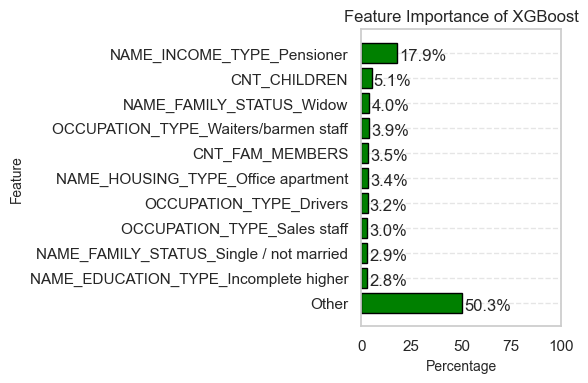

In [15]:
# 1) Extract raw feature importances and associate them with their column names
feature_names = X_train.columns
importances = xgb_clf.feature_importances_  # raw importances from the model

# Combine into a DataFrame
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# 2) Sort by importance descending
df_importances = df_importances.sort_values(by='importance', ascending=False)

# 3) Keep top 10 features, sum the rest into 'Other'
top_n = 10
top_features = df_importances.iloc[:top_n].copy()
others_sum = df_importances.iloc[top_n:]['importance'].sum()

# Create a new row for 'Other'
others_df = pd.DataFrame([{'feature': 'Other', 'importance': others_sum}])

# Concatenate top features + others
plot_df = pd.concat([top_features, others_df], ignore_index=True)

# 4) Convert raw importances to percentage
total_importance = plot_df['importance'].sum()
plot_df['percentage'] = 100.0 * plot_df['importance'] / total_importance

# 5) Plot a horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(plot_df['feature'], plot_df['percentage'], color='green', edgecolor='black')
plt.xlabel("Percentage", fontsize=10)
plt.ylabel("Feature", fontsize=10)
plt.title("Feature Importance of XGBoost", fontsize=12)

# Reverse the order so the top feature is at the top of the bar chart
plt.gca().invert_yaxis()

# Optionally annotate each bar with its percentage
for i, (feature, pct) in enumerate(zip(plot_df['feature'], plot_df['percentage'])):
    plt.text(pct + 1, i + 0.1, f"{pct:.1f}%", va='center')

plt.xlim(0, 100)  # ensure the axis goes from 0 to 100%

# Add horizontal gridlines (dashed) and remove vertical gridlines
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)
plt.grid(False, which='both', axis='x')

plt.tight_layout()
plt.show()

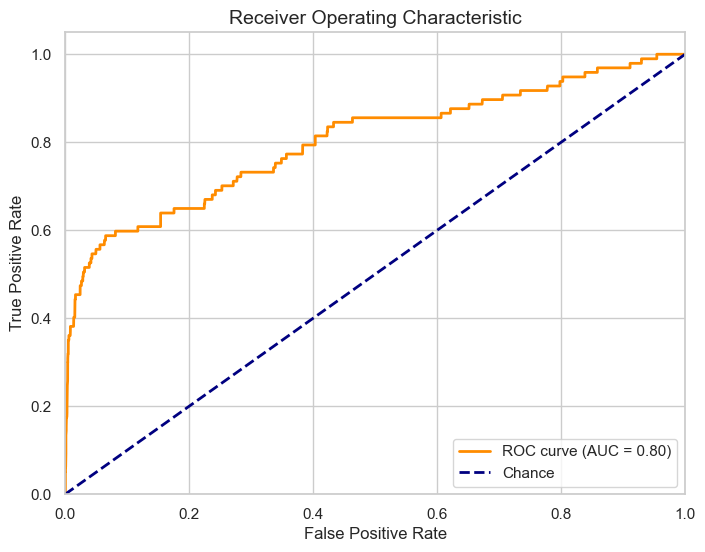

KS Statistic: 0.5223, p-value: 0.0000


In [16]:
# Get the probability predictions for the positive class.
y_pred_prob = xgb_clf.predict_proba(X_test)[:, 1]

# ---------------------------
# ROC Curve and AUC
# ---------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=14)
plt.legend(loc="lower right")
plt.show()

# ---------------------------
# KS Statistic
# ---------------------------
# Separate predicted probabilities for positives and negatives.
pos_probs = y_pred_prob[y_test == 1]
neg_probs = y_pred_prob[y_test == 0]
ks_stat, ks_pvalue = ks_2samp(pos_probs, neg_probs)
print("KS Statistic: {:.4f}, p-value: {:.4f}".format(ks_stat, ks_pvalue))

### Random Forests

Random Forest is a popular model for classification problems. It is an ensembling learning method which consist of multiple deicison trees, each tree will predict independently, and for classification problems the final predication is determined by majority voting. 

The training dataset for each tree is generated from bootstrapping (sampling with replacement), thus each tree will be trained on a random subset of the original training set. Each subset is different from each other, which reduces the overfiting problem. As even one tree overfitted, the combination of mutiple trees will further generalise the model. 

FINE TUNE METHOD: RANDOMIZED SEARCH 

Randomized search is a method which randomly select hyperparameter values within a given scope. Then cross validate every combination of parameters select the best model based on the chosen index, in this case it is f1 score. It is a balanced result of precision and recall. Accuracy is not suitable when over 90% of the target is 0.  

The advantages of this method is it cost less time and computation than Grid Search.  

Based on our settings, the program will have 100 different groups of hyperparameters, in each group we will cross validate 5 times. 

As the dataset has only 45 features, after several times adjustment the final scope was setted as follows: 

In [ ]:
# -------------------------------------------------------------------------
# RANDOM FOREST RANDOMIZEDSEARCH
# -------------------------------------------------------------------------

# Parameters
param_dist = {
    'n_estimators': randint(100, 500),   
    'max_depth': randint(5, 30),         
    'min_samples_split': randint(2, 20),  
    'min_samples_leaf': randint(1, 20),   
    'class_weight': ['balanced', None], 
    'max_features': ['sqrt', 'log2', 0.2, 0.5, None] 
}  

# Initiate a model 
rf_model = RandomForestClassifier(random_state=42)

# 5-cross validation, f1 score  
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring='f1',  
                                   random_state=42, n_jobs=-1)

random_search.fit(X_res, y_res)

# Save the output 
import pickle
with open('best_params.pkl', 'wb') as f:
    pickle.dump(random_search.best_params_, f)

# print for check 
print("Best parameters found: ", random_search.best_params_)
print("Best F1 score: ", random_search.best_score_)


Best parameters found:  {'class_weight': 'balanced', 'max_depth': 24, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 246}
Best F1 score:  0.9897413726747523


In [ ]:
#-------------------------------------------------------------------------
# OPTIMAL RF PARAMS
#-------------------------------------------------------------------------

with open('best_params.pkl', 'rb') as f:
    best_params = pickle.load(f)


rf_model_1= RandomForestClassifier(random_state=42, **best_params)

# Train
rf_model_1.fit(X_res, y_res)

# Test  
y_pred_1= rf_model_1.predict(X_test)

# Assess
print("Accuracy:", accuracy_score(y_test, y_pred_1))
print("Classification Report:")
print(classification_report(y_test, y_pred_1))

Accuracy: 0.9802475309413676
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7902
           1       0.26      0.33      0.29        97

    accuracy                           0.98      7999
   macro avg       0.62      0.66      0.64      7999
weighted avg       0.98      0.98      0.98      7999



### SVM

In [114]:
# ------------------------------------------------------------------------
# Using the oversampled training set (X_res, y_res) and the original test set (X_test, y_test)
# ------------------------------------------------------------------------

# Define a grid of hyperparameters to search over
param_grid = {
    'C': [0.1, 0.5, 1, 10, 100, 1000, 10000],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']  # gamma is used for non-linear kernels
}

# Initialize the SVM classifier
svm_clf = SVC(random_state=42)

# Setup GridSearchCV with 5-fold cross-validation on the oversampled training set
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_res, y_res)

# Print the optimal hyperparameters and best CV score
print("Optimal SVM Hyperparameters:")
print(grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.4f}".format(accuracy))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Optimal SVM Hyperparameters:
{'C': 10000, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9741

Test Accuracy: 0.9564

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7902
           1       0.13      0.44      0.20        97

    accuracy                           0.96      7999
   macro avg       0.56      0.70      0.59      7999
weighted avg       0.98      0.96      0.97      7999

Confusion Matrix:
[[7607  295]
 [  54   43]]


In [ ]:
#-------------------------------------------------------------------------
# OPTIMAL SVM PARAMS
#-------------------------------------------------------------------------

# 1) Define the SVM classifier
svm_clf = SVC(
    kernel='rbf',       # Common choice; can also be 'linear', 'poly', etc.
    C=10000,              # Regularization parameter
    gamma='scale',      # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
    random_state=42     # For reproducibility
)

# 2) Fit the SVM model on the training data
svm_clf.fit(X_res, y_res)

# 3) Make predictions on the test set
y_pred = svm_clf.predict(X_test)

# 4) Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9564

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7902
           1       0.13      0.44      0.20        97

    accuracy                           0.96      7999
   macro avg       0.56      0.70      0.59      7999
weighted avg       0.98      0.96      0.97      7999

Confusion Matrix:
[[7607  295]
 [  54   43]]


Result:
The random Forest model performs much better than SVM but still weaker than XGBoost. The possible reason might be XGBoost has more hyperparameters thus it has higher flexibility than Random Forest. Additionally XGBoost may perform better in handling the interactions between features as it is a boosting model, as it is always updating and correcing its model which could help to capture the complex relationship between the features. While random forest is a bagging model, the training in each decision tree is parralled without iteration, thus it might performs a bit weaker the XGBoost. 

### LSTM

In [ ]:
#-------------------------------------------------------------------------
# BUILD LSTM Model
#-------------------------------------------------------------------------

X_train_lstm = np.array(X_res).reshape(X_res.shape[0], 1, X_res.shape[1])
X_test_lstm = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

X_train_lstm = X_train_lstm.astype('float32')
X_test_lstm = X_test_lstm.astype('float32')
y_train_lstm = y_res.astype('float32')
y_test_lstm = y_test.astype('float32')

def build_lstm_model(hp):
    lstm_units1 = hp.Int('lstm_units1', min_value=32, max_value=128, step=32)
    lstm_units2 = hp.Int('lstm_units2', min_value=32, max_value=128, step=32)
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=16)
    dropout_rate = hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu', 'selu'])
    learning_rate = hp.Choice('lr', [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])
    optimizer = hp.Choice('optimizer', ['adam', 'nadam', 'rmsprop'])
    inputs = Input(shape=(1, X_train_lstm.shape[2]))
    x = LSTM(
        units=lstm_units1,
        return_sequences=True,
        activation=activation,
        kernel_initializer='he_normal',
        recurrent_dropout=hp.Float('recurrent_dropout1', 0.1, 0.3, step=0.1)
    )(inputs)
    x = BatchNormalization()(x)
    x = LSTM(
        units=lstm_units2,
        activation=activation,
        kernel_initializer='he_normal',
        recurrent_dropout=hp.Float('recurrent_dropout2', 0.1, 0.3, step=0.1)
    )(x)
    x = BatchNormalization()(x)
    
    x = Dense(dense_units, activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, clipvalue=0.5)
    elif optimizer == 'nadam':
        opt = Nadam(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

def run_hyperparameter_tuning():
    temp_dir = tempfile.mkdtemp()
    tuner = kt.BayesianOptimization(
        build_lstm_model,
        objective=kt.Objective('val_auc', direction='max'),
        max_trials=30,
        executions_per_trial=1,
        directory=temp_dir,
        project_name='credit_risk_lstm'
    )
    early_stop = EarlyStopping(
        monitor='val_auc',
        patience=10,
        mode='max',
        restore_best_weights=True
    )
    print("\nsearching hyperparameters...")
    tuner.search(
        X_train_lstm, y_train_lstm,
        epochs=50,
        batch_size=256,
        validation_data=(X_test_lstm, y_test_lstm),
        callbacks=[early_stop],
        verbose=1
    )
    
    best_model = tuner.get_best_models(num_models=1)[0]
    best_hp = tuner.get_best_hyperparameters()[0]
    
    print("\noptimal LSTM hyperparameters:")
    for param, value in best_hp.values.items():
        print(f"{param}: {value}")
    
    return best_model


optimized_lstm_model = run_hyperparameter_tuning()
optimized_lstm_model.summary()

final_history = optimized_lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=256,
    callbacks=[
        EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True)
    ],
    verbose=1
)
test_loss, test_acc, test_auc, test_precision, test_recall = optimized_lstm_model.evaluate(
    X_test_lstm, y_test_lstm, verbose=0)

def evaluate_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
 
    print("\n" + "="*60)
    print("Enhanced LSTM Model Comprehensive Evaluation")
    print("="*60)
    print(f"Test Accuracy: {test_acc:.4f}")
    print("\n>>> Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

    conf_mat = confusion_matrix(y_test, y_pred)
    conf_df = pd.DataFrame(conf_mat, 
                          index=['Actual Good', 'Actual Bad'],
                          columns=['Predicted Good', 'Predicted Bad'])
    print("\n>>> Confusion Matrix:")
    print(conf_df)

    TN, FP, FN, TP = conf_mat.ravel()
    total = TN + FP + FN + TP
    
    metrics = {
        'Bad Customer Capture Rate (Recall)': TP / (TP + FN),
        'Good Customer Accuracy': TN / (TN + FP),
        'Composite Risk Score': (FP + FN) / total
    }
    
    print("\n>>> Key Business Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.2%}")

evaluate_model(optimized_lstm_model, X_test_lstm, y_test)

Trial 30 Complete [00h 02m 12s]
val_auc: 0.784904420375824

Best val_auc So Far: 0.784904420375824
Total elapsed time: 01h 05m 26s

optimal LSTM hyperparameters:
lstm_units1: 128
lstm_units2: 32
dense_units: 112
dropout: 0.1
activation: elu
lr: 0.005
optimizer: nadam
recurrent_dropout1: 0.1
recurrent_dropout2: 0.1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 45)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            89088     
                                                                 
 batch_normalization (Batch  (None, 1, 128)            512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
         

145/145 [==============================] - 4s 26ms/step - loss: 0.0515 - accuracy: 0.9838 - auc: 0.9972 - precision: 0.9787 - recall: 0.9891
Epoch 16/50
145/145 [==============================] - 4s 26ms/step - loss: 0.0608 - accuracy: 0.9809 - auc: 0.9964 - precision: 0.9741 - recall: 0.9881
Epoch 17/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0482 - accuracy: 0.9844 - auc: 0.9976 - precision: 0.9790 - recall: 0.9900
Epoch 18/50
145/145 [==============================] - 4s 26ms/step - loss: 0.0484 - accuracy: 0.9849 - auc: 0.9975 - precision: 0.9785 - recall: 0.9915
Epoch 19/50
145/145 [==============================] - 4s 27ms/step - loss: 0.0559 - accuracy: 0.9821 - auc: 0.9971 - precision: 0.9763 - recall: 0.9881
Epoch 20/50
145/145 [==============================] - 4s 27ms/step - loss: 0.0426 - accuracy: 0.9868 - auc: 0.9979 - precision: 0.9815 - recall: 0.9922
Epoch 21/50
145/145 [==============================] - 4s 27ms/step - loss: 0.0573 - accuracy:

Epoch 34/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0404 - accuracy: 0.9874 - auc: 0.9980 - precision: 0.9832 - recall: 0.9919
Epoch 35/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0548 - accuracy: 0.9820 - auc: 0.9972 - precision: 0.9747 - recall: 0.9897
Epoch 36/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0421 - accuracy: 0.9862 - auc: 0.9980 - precision: 0.9822 - recall: 0.9903
Epoch 37/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0528 - accuracy: 0.9831 - auc: 0.9973 - precision: 0.9768 - recall: 0.9897
Epoch 38/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0437 - accuracy: 0.9868 - auc: 0.9979 - precision: 0.9815 - recall: 0.9922
Epoch 39/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0378 - accuracy: 0.9883 - auc: 0.9985 - precision: 0.9835 - recall: 0.9933
Epoch 40/50
145/145 [==============================] - 4s 25ms/step - loss: 0.0534

### MLP

In [ ]:
#-------------------------------------------------------------------------
# BUILD MLP Model # attempt 1
#-------------------------------------------------------------------------

model = Sequential([
    Dense(64, activation='relu', input_dim=X_res.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

initial_epochs = 20
history = model.fit(
    X_res, y_res,
    batch_size=32,
    epochs=initial_epochs,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1)],
    verbose=2
)

for layer in model.layers[:1]:  
    layer.trainable = False

optimizer_ft = SGD(learning_rate=0.001, momentum=0.9)  
model.compile(optimizer=optimizer_ft, loss='binary_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
)

fine_tune_epochs = 10
history_ft = model.fit(
    X_res, y_res,
    batch_size=32,
    epochs=fine_tune_epochs,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, EarlyStopping(monitor='val_loss', patience=3, verbose=1)],
    verbose=2
)

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)
test_accuracy = np.mean(y_pred == y_test)

print("="*60)
print(f"Fine-tuned Model Comprehensive Evaluation")
print(f"Test Accuracy: {test_accuracy:.4f}\n")

print(">>> Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=["Good", "Bad"],  
    digits=2
))

cm = confusion_matrix(y_test, y_pred)
print("\n>>> Confusion Matrix:")
print(f"{'':<15}{'Predicted Good':<15}{'Predicted Bad':<15}")
print(f"{'Actual Good':<15}{cm[0,0]:<15}{cm[0,1]:<15}")
print(f"{'Actual Bad':<15}{cm[1,0]:<15}{cm[1,1]:<15}")

precision_good = cm[0,0] / (cm[0,0] + cm[1,0])
recall_bad = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"\n[Key Metrics] Good Precision: {precision_good:.2f}, Bad Recall: {recall_bad:.2f}")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1153/1153 - 4s - 3ms/step - accuracy: 0.7204 - loss: 0.5424 - val_accuracy: 0.9091 - val_loss: 0.2792
Epoch 2/20
1153/1153 - 1s - 1ms/step - accuracy: 0.8392 - loss: 0.3521 - val_accuracy: 0.9287 - val_loss: 0.1976
Epoch 3/20
1153/1153 - 2s - 1ms/step - accuracy: 0.8807 - loss: 0.2815 - val_accuracy: 0.8424 - val_loss: 0.3557
Epoch 4/20
1153/1153 - 1s - 1ms/step - accuracy: 0.9009 - loss: 0.2402 - val_accuracy: 0.9197 - val_loss: 0.1951
Epoch 5/20
1153/1153 - 2s - 2ms/step - accuracy: 0.9113 - loss: 0.2163 - val_accuracy: 0.9162 - val_loss: 0.2089
Epoch 6/20
1153/1153 - 2s - 1ms/step - accuracy: 0.9211 - loss: 0.1987 - val_accuracy: 0.9111 - val_loss: 0.2136
Epoch 7/20
1153/1153 - 2s - 1ms/step - accuracy: 0.9275 - loss: 0.1797 - val_accuracy: 0.9284 - val_loss: 0.1734
Epoch 8/20
1153/1153 - 1s - 1ms/step - accuracy: 0.9342 - loss: 0.1698 - val_accuracy: 0.9176 - val_loss: 0.2127
Epoch 9/20
1153/1153 - 2s - 1ms/step - accuracy: 0.9367 - loss: 0.1615 - val_accuracy: 0.9406 - val_loss: 0

In [ ]:
#-------------------------------------------------------------------------
# BUILD MLP Model # attempt 2
#-------------------------------------------------------------------------

model = Sequential([
    Input(shape=(X_res.shape[1],)),  
    Dense(64, activation='relu'),    
    Dense(1, activation='sigmoid')   
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(X_res, y_res, epochs=10, batch_size=256, verbose=0)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\n" + "="*60)
print("Neural Network Model Evaluation")
print("="*60)
print(f"Test Accuracy: {test_accuracy:.4f}")  

print("\n>>> Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("\n>>> Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step

Neural Network Model Evaluation
Test Accuracy: 0.8432

>>> Classification Report:
              precision    recall  f1-score   support

        Good       0.99      0.85      0.91      7902
         Bad       0.04      0.45      0.07        97

    accuracy                           0.84      7999
   macro avg       0.51      0.65      0.49      7999
weighted avg       0.98      0.84      0.90      7999


>>> Confusion Matrix:
[[6701 1201]
 [  53   44]]


In [ ]:
#-------------------------------------------------------------------------
# BUILD MLP Model # attempt 3
#-------------------------------------------------------------------------

model = Sequential([
    Dense(64, activation='relu', input_dim=X_res.shape[1], kernel_initializer='he_normal'),
    BatchNormalization(), 
    Dropout(0.2),         
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

initial_optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=initial_optimizer, loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])  

initial_epochs = 30  
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1
)
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', verbose=1)  

history = model.fit(
    X_res, y_res,
    batch_size=32,
    epochs=initial_epochs,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping],  
    verbose=2
)

fine_tune_optimizer = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)  
model.compile(optimizer=fine_tune_optimizer, loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

fine_tune_epochs = 15
history_ft = model.fit(
    X_res, y_res,
    batch_size=32,
    epochs=fine_tune_epochs,
    validation_data=(X_test, y_test),
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7),
        EarlyStopping(monitor='val_auc', patience=3, mode='max')
    ],
    verbose=2
)

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Test Accuracy:", np.mean(y_pred == y_test))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1153/1153 - 5s - 4ms/step - AUC: 0.7983 - accuracy: 0.7219 - loss: 0.5425 - val_AUC: 0.6978 - val_accuracy: 0.8224 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 2/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


1153/1153 - 2s - 2ms/step - AUC: 0.9025 - accuracy: 0.8196 - loss: 0.3929 - val_AUC: 0.7100 - val_accuracy: 0.8949 - val_loss: 0.2505 - learning_rate: 0.0010
Epoch 3/30
1153/1153 - 2s - 2ms/step - AUC: 0.9307 - accuracy: 0.8515 - loss: 0.3345 - val_AUC: 0.7361 - val_accuracy: 0.8810 - val_loss: 0.2582 - learning_rate: 0.0010
Epoch 4/30
1153/1153 - 2s - 2ms/step - AUC: 0.9437 - accuracy: 0.8695 - loss: 0.3012 - val_AUC: 0.7441 - val_accuracy: 0.8941 - val_loss: 0.2369 - learning_rate: 0.0010
Epoch 5/30
1153/1153 - 2s - 2ms/step - AUC: 0.9513 - accuracy: 0.8813 - loss: 0.2805 - val_AUC: 0.7523 - val_accuracy: 0.8770 - val_loss: 0.2592 - learning_rate: 0.0010
Epoch 6/30
1153/1153 - 2s - 2ms/step - AUC: 0.9554 - accuracy: 0.8855 - loss: 0.2683 - val_AUC: 0.7449 - val_accuracy: 0.9071 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 7/30
1153/1153 - 2s - 2ms/step - AUC: 0.9601 - accuracy: 0.8920 - loss: 0.2538 - val_AUC: 0.7514 - val_accuracy: 0.9000 - val_loss: 0.2386 - learning_rate: 0.00

/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,accuracy,loss,val_AUC,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


1153/1153 - 2s - 2ms/step - AUC: 0.9762 - accuracy: 0.9218 - loss: 0.1942 - val_AUC: 0.7675 - val_accuracy: 0.9260 - val_loss: 0.1958 - learning_rate: 1.0000e-04
Epoch 3/15
1153/1153 - 2s - 2ms/step - AUC: 0.9755 - accuracy: 0.9229 - loss: 0.1974 - val_AUC: 0.7695 - val_accuracy: 0.9335 - val_loss: 0.1735 - learning_rate: 1.0000e-04
Epoch 4/15
1153/1153 - 2s - 2ms/step - AUC: 0.9763 - accuracy: 0.9231 - loss: 0.1939 - val_AUC: 0.7687 - val_accuracy: 0.9307 - val_loss: 0.1788 - learning_rate: 1.0000e-04
Epoch 5/15
1153/1153 - 2s - 2ms/step - AUC: 0.9771 - accuracy: 0.9247 - loss: 0.1908 - val_AUC: 0.7694 - val_accuracy: 0.9264 - val_loss: 0.1916 - learning_rate: 1.0000e-04
Epoch 6/15
1153/1153 - 2s - 2ms/step - AUC: 0.9765 - accuracy: 0.9237 - loss: 0.1932 - val_AUC: 0.7697 - val_accuracy: 0.9279 - val_loss: 0.1889 - learning_rate: 1.0000e-05
Epoch 7/15
1153/1153 - 2s - 2ms/step - AUC: 0.9772 - accuracy: 0.9245 - loss: 0.1909 - val_AUC: 0.7723 - val_accuracy: 0.9280 - val_loss: 0.1878 -

### Logistic Regression

In [ ]:
# -------------------------------------------------------------------------
# LOGREG GRIDSEARCH
# -------------------------------------------------------------------------

# ------------------------------------------------------------------------
# Assume that X_res, y_res are our oversampled training data (via SMOTE)
# and X_test, y_test are our test set splits from our pre-processing steps.
# ------------------------------------------------------------------------

# Build a pipeline for Logistic Regression (data are assumed to be normalised already)
pipeline_lr = Pipeline([
    ('clf', LogisticRegression(max_iter=10000, random_state=42))
])

# Define a grid of hyperparameters including models with no penalty, L1, and L2 regularisation.
param_grid_lr = [
    {
        'clf__penalty': [None],
        'clf__solver': ['saga', 'newton-cg', 'sag', 'lbfgs']
    },
    {
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear', 'saga'],
        'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
]

# Setup GridSearchCV with 5-fold cross-validation on the oversampled training set
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_lr.fit(X_res, y_res)

print("Optimal Logistic Regression Hyperparameters:")
print(grid_search_lr.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search_lr.best_score_))

# Evaluate the best model on the test set
y_pred_lr = grid_search_lr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_lr)
print("\nTest Accuracy: {:.4f}".format(test_accuracy))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


Optimal Logistic Regression Hyperparameters:
{'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
Best cross-validation accuracy: 0.7181

Test Accuracy: 0.7342

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      7902
           1       0.02      0.42      0.04        97

    accuracy                           0.73      7999
   macro avg       0.50      0.58      0.44      7999
weighted avg       0.98      0.73      0.84      7999

Confusion Matrix:
[[5832 2070]
 [  56   41]]


In [109]:
#-------------------------------------------------------------------------
# OPTIMAL LOGREG PARAMS
#-------------------------------------------------------------------------

# Create and fit the Logistic Regression model with the optimal parameters
clf = LogisticRegression(C=0.1, penalty='l1', solver='saga', max_iter=10000, random_state=42)
clf.fit(X_res, y_res)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7342

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      7902
           1       0.02      0.42      0.04        97

    accuracy                           0.73      7999
   macro avg       0.50      0.58      0.44      7999
weighted avg       0.98      0.73      0.84      7999

Confusion Matrix:
[[5832 2070]
 [  56   41]]


### Mixed Sampling

SMOTE-Tomek

In [ ]:
# -------------------------------------------------------------------------
# SMOTE-TOMEK
# -------------------------------------------------------------------------

y = final_df['target']
X = final_df.drop('target', axis=1)

#  Drop flags
X = X.drop(['CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1)

#   train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#  Normalize  features
CNT_CHILDREN_scaler = MinMaxScaler()
AMT_INCOME_TOTAL_scaler = MinMaxScaler()
CNT_FAM_MEMBERS_scaler = MinMaxScaler()
age_months_scaler = MinMaxScaler()
employment_months_scaler = MinMaxScaler()

X_train['CNT_CHILDREN'] = CNT_CHILDREN_scaler.fit_transform(X_train[['CNT_CHILDREN']])
X_train['AMT_INCOME_TOTAL'] = AMT_INCOME_TOTAL_scaler.fit_transform(X_train[['AMT_INCOME_TOTAL']])
X_train['CNT_FAM_MEMBERS'] = CNT_FAM_MEMBERS_scaler.fit_transform(X_train[['CNT_FAM_MEMBERS']])
X_train['age_months'] = age_months_scaler.fit_transform(X_train[['age_months']])
X_train['employment_months'] = employment_months_scaler.fit_transform(X_train[['employment_months']])

X_test['CNT_CHILDREN'] = CNT_CHILDREN_scaler.transform(X_test[['CNT_CHILDREN']])
X_test['AMT_INCOME_TOTAL'] = AMT_INCOME_TOTAL_scaler.transform(X_test[['AMT_INCOME_TOTAL']])
X_test['CNT_FAM_MEMBERS'] = CNT_FAM_MEMBERS_scaler.transform(X_test[['CNT_FAM_MEMBERS']])
X_test['age_months'] = age_months_scaler.transform(X_test[['age_months']])
X_test['employment_months'] = employment_months_scaler.transform(X_test[['employment_months']])


# Downsample majority to 10K
rus = RandomUnderSampler(sampling_strategy={0: 10000}, random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

#  SMOTE + Tomek to upsample minority to 10,000
smt = SMOTETomek(sampling_strategy={1: 10000}, random_state=42)
X_res_tomek, y_res_tomek = smt.fit_resample(X_rus, y_rus)


# Define an expanded parameter grid.
param_grid = {
    'max_depth': [8, 10, 12, 14],
    'n_estimators': [100, 250, 400],
    'min_child_weight': [6, 8, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier with fixed parameters.
xgb_clf = xgb.XGBClassifier(
    seed=60,
    objective="binary:logistic"
)

# Setup GridSearchCV with 5-fold cross-validation and using all CPU cores.
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 4. Fit on resampled data (from SMOTE + Tomek)
grid_search.fit(X_res_tomek, y_res_tomek)
# 5. Print best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best accuracy score on resampled training set:", grid_search.best_score_)

# 6. Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob).round(4))


/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 6, 'n_estimators': 400, 'subsample': 0.8}
Best accuracy score on resampled training set: 0.9833488497124282

Classification Report on Test Set:
              precision    recall  f1-score   support

           0      0.992     0.985     0.988      7902
           1      0.228     0.371     0.282        97

    accuracy                          0.977      7999
   macro avg      0.610     0.678     0.635      7999
weighted avg      0.983     0.977     0.980      7999

Test ROC-AUC: 0.8012


SMOTE-ENN

In [ ]:
# -------------------------------------------------------------------------
# SMOTE-ENN
# -------------------------------------------------------------------------

#  Downsample majority to 10,000
X_rus2, y_rus2 = rus.fit_resample(X_train, y_train)

#  SMOTEENN to upsample minority to 10,000
sme = SMOTEENN(sampling_strategy={1: 10000}, random_state=42)
X_res_enn, y_res_enn = sme.fit_resample(X_rus2, y_rus2)

# Define an expanded parameter grid.
param_grid = {
    'max_depth': [8, 10, 12, 14],
    'n_estimators': [100, 250, 400],
    'min_child_weight': [6, 8, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the XGBoost classifier with fixed parameters.
xgb_clf = xgb.XGBClassifier(
    seed=60,
    objective="binary:logistic"
)

# Setup GridSearchCV with 5-fold cross-validation and using all CPU cores.
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the oversampled training data.
grid_search.fit(X_res_enn, y_res_enn)

print("Best CV Accuracy: {:.4f}".format(grid_search.best_score_))
print("Best Parameters:", grid_search.best_params_)

# Evaluate the best model on the test set.
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.4f}".format(accuracy))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tomasromeiro/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best CV Accuracy: 0.9912
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 6, 'n_estimators': 400, 'subsample': 0.8}
Test Accuracy: 0.9657

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7902
           1       0.16      0.41      0.23        97

    accuracy                           0.97      7999
   macro avg       0.57      0.69      0.60      7999
weighted avg       0.98      0.97      0.97      7999

Confusion Matrix:
[[7685  217]
 [  57   40]]
